<div>
<img src="https://drive.google.com/uc?export=view&id=1vK33e_EqaHgBHcbRV_m38hx6IkG0blK_" width="350"/>
</div> 

#**Artificial Intelligence - MSc**
##ET5003 - MACHINE LEARNING APPLICATIONS 

###Instructor: Enrique Naredo
###ET5003_Etivity-2

In [1]:
#@title Current Date
Today = '2021-09-26' #@param {type:"date"}


In [2]:
#@markdown ---
#@markdown ### Enter your details here:
Student_ID = "20151586" #@param {type:"string"}
Student_full_name = "Carlos Siqueira do Amaral" #@param {type:"string"}
#@markdown ---

In [3]:
#@title Notebook information
Notebook_type = 'Assignment' #@param ["Example", "Lab", "Practice", "Etivity", "Assignment", "Exam"]
Version = 'Draft' #@param ["Draft", "Final"] {type:"raw"}
Submission = False #@param {type:"boolean"}

# INTRODUCTION

**Piecewise regression**, extract from [Wikipedia](https://en.wikipedia.org/wiki/Segmented_regression):

Segmented regression, also known as piecewise regression or broken-stick regression, is a method in regression analysis in which the independent variable is partitioned into intervals and a separate line segment is fit to each interval. 

* Segmented regression analysis can also be performed on 
multivariate data by partitioning the various independent variables. 
* Segmented regression is useful when the independent variables, clustered into different groups, exhibit different relationships between the variables in these regions. 

* The boundaries between the segments are breakpoints.

* Segmented linear regression is segmented regression whereby the relations in the intervals are obtained by linear regression. 

***The goal is to use advanced Machine Learning methods to predict House price.***

## Imports

In [4]:
import os
import pandas as pd
import numpy as np
import pymc3 as pm
import arviz as az
import theano as tt

# to plot
import matplotlib.colors
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm

# Sklearn
import sklearn.datasets as dt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline

# Custom notebook style
from jupyterthemes import jtplot as jt

jt.style()
%matplotlib inline
%load_ext lab_black

print(f"pymc3 version: {pm.__version__}")
print(f"arviz version: {az.__version__}")
print(f"theano version: {tt.__version__}")
!python --version

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


pymc3 version: 3.11.4
arviz version: 0.11.2
theano version: 1.1.2
Python 3.7.11


In [5]:
# Define the seed so that results can be reproduced
seed = 11
rand_state = 1

# Define the color maps for plots
# color_map = plt.cm.get_cmap('RdYlBu')
# color_map_discrete = matplotlib.colors.LinearSegmentedColormap.from_list("", ["red","cyan","magenta","blue"])

# DATASET

Extract from this [paper](https://ieeexplore.ieee.org/document/9300074):

* House prices are a significant impression of the economy, and its value ranges are of great concerns for the clients and property dealers. 

* Housing price escalate every year that eventually reinforced the need of strategy or technique that could predict house prices in future. 

* There are certain factors that influence house prices including physical conditions, locations, number of bedrooms and others.


1. [Download the dataset](https://github.com/UL-ET5003/ET5003_SEM1_2021-2/tree/main/Week-3). 

2. Upload the dataset into your folder.



The challenge is to predict the final price of each house.

# Data Preparation

## Loading datasets

In [6]:
fpath = os.path.join(os.getcwd(), "house_prices")

train_fname = "house_train.csv"
test_fname = "house_test.csv"
cost_fname = "true_price.csv"

train_set = pd.read_csv(os.path.join(fpath, train_fname)).drop(columns="ad_id")
X_test = pd.read_csv(os.path.join(fpath, test_fname)).drop(columns="ad_id")
y_test = pd.read_csv(os.path.join(fpath, cost_fname)).drop(columns="Id")

print("Loaded training data of shape", train_set.shape)
print("Loaded test data of shape", X_test.shape)
print("Loaded cost data of shape", y_test.shape)

Loaded training data of shape (2982, 16)
Loaded test data of shape (500, 15)
Loaded cost data of shape (500, 1)


There are some entries with null values for `price` in the training set, let's remove them


In [7]:
print("Training set rows with no house price:", train_set["price"].isna().sum())

train_set = train_set[train_set["price"].notna()]

Training set rows with no house price: 90


In [8]:
train_set.sample(5)

,area,bathrooms,beds,ber_classification,county,description_block,environment,facility,features,latitude,longitude,no_of_units,price,property_category,property_type,surface
2498,Beaumont,1.0,3.0,NaN,Dublin,Forbes Boyle are delighted to bring to the mar...,prod,"Parking,Alarm,Oil Fired Central Heating",Phone watch alarm\nUPVC double glazed windows\...,53.379796,-6.223356,NaN,410000.0,sale,semi-detached,97.0
551,Artane,2.0,3.0,D2,Dublin,DNG are delighted to present to the market no ...,prod,"Parking,Gas Fired Central Heating,Alarm",Sought after location. \nLarge south facing re...,53.385714,-6.196458,NaN,335000.0,sale,terraced,95.0
770,Adamstown,2.0,3.0,B3,Dublin,PROPERTY PARTNERS O BRIEN SWAINE are delighted...,prod,NaN,None,53.335962,-6.455811,NaN,284950.0,sale,semi-detached,125.0
2917,Clonsilla,2.0,2.0,D1,Dublin,"DNG are delighted to present 56 The Courtyard,...",prod,NaN,None,53.380905,-6.403229,NaN,260000.0,sale,terraced,77.0
2879,Foxrock,3.0,4.0,B1,Dublin,'The Corrin' is a truly impressive detached pr...,prod,NaN,Double Glazed Windows\nGas fired underfloor he...,53.267516,-6.170837,NaN,1800000.0,sale,detached,289.1


## Data Exploration

Some features that could influence house price are more or less intuitive, for example:
- area (which could also be encoded with latitude/longitude)
- bathrooms
- beds
- surface

But there are other features which need further analysis to decide whether they should be included or not.
- ber_classification
- property_type
- property_category
What are some features that could possibly be useful?

There's also the case of `facility` which could be interesting to analyse but has many values and could add noise.

In [9]:
def add_labels_barh(x, y, axis, **kwargs):
    """Adds label values to a horizontal barplot
    
    Parameters
    ----------
    x : pd.Series
        Heights of the bars
    y : pd.Series
        The value labels of each bar
    axis : matplotlib.pyplot.axis
        The axes to plot
    
    Returns
    -------
    None
    """
    for y_pos, x_pos in enumerate(x):
        axis.text(x_pos + 2, y_pos - 0.2, y[y_pos], **kwargs)


def format_prices(x):
    """Helper function to format the mean and median house prices to text.
    To be used as part of a pd.Series.apply method.

    Parameters
    ----------
    x : iterable
        Pair containing mean and median house prices, respectively
    
    Returns
    -------
        A string with the formatted prices, in hundred thousands

    """
    mean, median = x
    return f"({mean/100_000:.1f}K, {median/100_000:,.1f}K)"


def agg_count_plot(data, feature, target, ax, **plot_kwargs):
    """Aggregates data on a given feature, and creates a horizontal bar plot
    labelled with the mean and median of the target feature in hundreds of thousands

    Parameters
    ----------
    data : pd.DataFrame
        Data to aggregate.
    feature : str
        Name of Data column to analyse.
    target : str
        Name of data column with target variable
    ax : matplotlib.pyplot.axis
        The axes to plot
        
    Returns
    -------
    None
    """
    agg_df = (
        data[[feature, target]]
        .groupby(feature)
        .agg(
            count=(feature, "count"),
            mean_price=(target, "mean"),
            median_price=(target, "median"),
        )
    )

    agg_df["count"].sort_index(ascending=False).plot(kind="barh", ax=ax, **plot_kwargs)
    add_labels_barh(
        agg_df["count"][::-1],
        agg_df[[f"mean_{target}", f"median_{target}"]].apply(format_prices, axis=1)[
            ::-1
        ],
        ax,
    )
    ax.set_ylabel("")

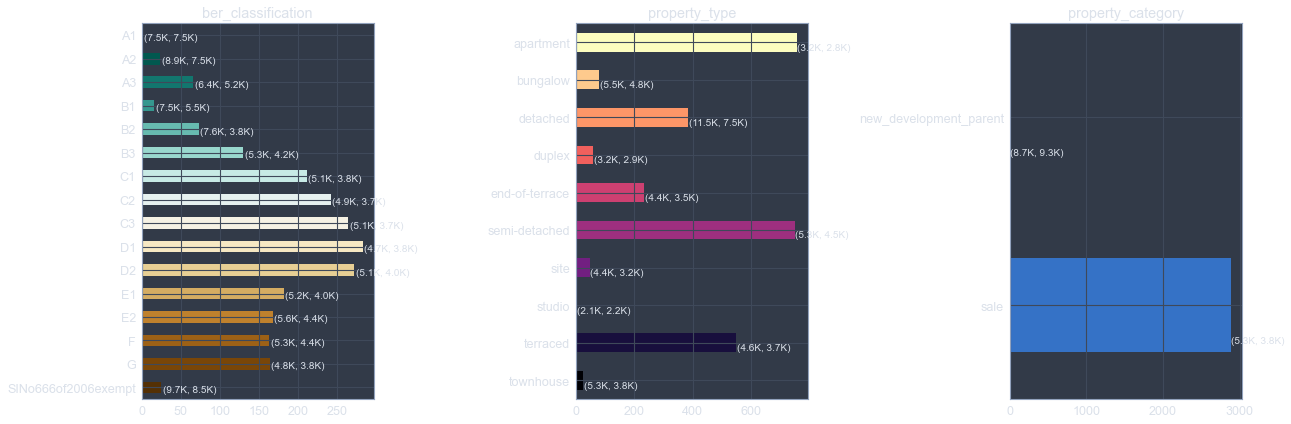

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot for ber classification
unique_ber = train_set["ber_classification"].nunique()
ber_cmap = cm.get_cmap("BrBG", unique_ber)
ber_colors = [ber_cmap(i) for i in range(unique_ber)]
agg_count_plot(
    train_set,
    "ber_classification",
    "price",
    ax=axes[0],
    color=ber_colors,
    title="ber_classification",
)

unique_types = train_set["property_type"].nunique()
type_cmap = cm.get_cmap("magma", unique_types)
type_colors = [type_cmap(i) for i in range(unique_types)]
agg_count_plot(
    train_set,
    "property_type",
    "price",
    ax=axes[1],
    title="property_type",
    color=type_colors,
)

agg_count_plot(
    train_set, "property_category", "price", ax=axes[2], title="property_category"
)

fig.tight_layout()
plt.show()

Some notes:

`ber_classification` and `property_type` do seem to have some impact on the mean and median house prices at different levels, while the class imbalance of `property_category` types makes it hard to make any conclusions. The `ber_classification` price varies a bit, while `property_type` has  bigger rance between mean and median values.

I'll encode `ber_classification` and `property_type` and use these as features.

In [11]:
train_set["county"].value_counts()

Dublin    2892
Name: county, dtype: int64

As there are only entries for Dublin, the feature `county` is not useful.

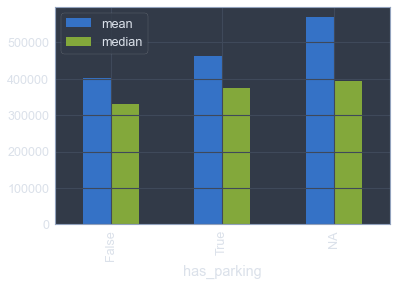

NA       1942
True      839
False     111
Name: has_parking, dtype: int64

In [12]:
train_set["has_parking"] = train_set["facility"].str.contains("Parking").fillna("NA")
train_set.groupby("has_parking")["price"].agg(["mean", "median"]).plot(kind="bar")
plt.show()

train_set["has_parking"].value_counts()

Looks like there's also a slight difference in the prices of houses that have parking and those that don't, but there are many missing values for this feature, so I won't use it either.

### Latitude / Longitude

An inspection of these variables showed two entries that appear to have been incorrectly input as they point to places outside of Ireland

In [13]:
train_set[train_set["latitude"] < 53]

,area,bathrooms,beds,ber_classification,county,description_block,environment,facility,features,latitude,longitude,no_of_units,price,property_category,property_type,surface,has_parking
767,Clondalkin,1.0,3.0,NaN,Dublin,RAY COOKE AUCTIONEERS take great pleasure in i...,prod,NaN,None,52.501856,-1.744995,NaN,199000.0,sale,semi-detached,79.0,NA
861,Glenageary,2.0,4.0,F,Dublin,LEONARD WILSON KEENAN ESTATE &amp; LETTING AGE...,prod,NaN,None,51.458439,-2.496219,NaN,795000.0,sale,semi-detached,NaN,NA


In [14]:
# Remove wrong entries
train_set = train_set[train_set["latitude"] > 53]

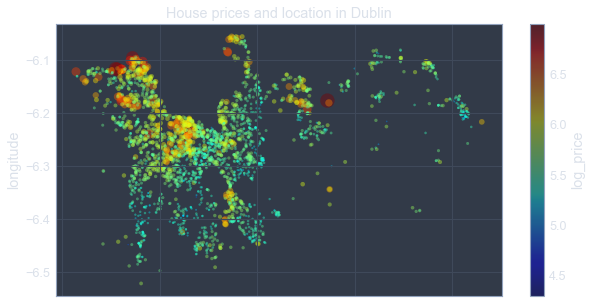

In [15]:
train_set.loc[:, "log_price"] = np.log10(train_set.loc[:, "price"],)
train_set.plot.scatter(
    "latitude",
    "longitude",
    s=train_set["price"] / 50_000,
    c="log_price",
    cmap="jet",
    figsize=(10, 5),
    alpha=0.4,
)
plt.xlabel("latitude")
plt.title("House prices and location in Dublin")
plt.show()

Instead of encoding `area` for feature, I'll use Latitude and longitude instead, as this can be a way to differentiate on house prices.

## Feature engineering

Encoding categorical variables and scaling.

In [16]:
drop_cols = [
    "area",
    "county",
    "description_block",
    "environment",
    "facility",
    "features",
    "has_parking",
    "no_of_units",
    "property_category",
    "price",
]
train_set = train_set.drop(columns=drop_cols)
train_set.head()

,bathrooms,beds,ber_classification,latitude,longitude,property_type,surface,log_price
15,3.0,5.0,A3,53.400454,-6.445730,detached,321.0,5.970812
26,4.0,4.0,A3,53.316410,-6.385214,semi-detached,144.0,5.685742
27,3.0,5.0,A3,53.401414,-6.446634,detached,321.0,5.970812
35,5.0,5.0,A2,53.375377,-6.056749,detached,312.0,6.168792
38,2.0,2.0,A3,53.372130,-6.338466,apartment,83.0,5.612784


Train / test split

In [70]:
num_cols = ["bathrooms", "beds", "latitude", "longitude", "surface"]
one_hot_cols = ["property_type"]
ordinal_cols = ["ber_classification"]
column_order = num_cols + ordinal_cols + one_hot_cols

train_set = train_set[column_order + ["log_price"]].dropna(axis=0)

X_train, y_train = (
    train_set.drop(columns=["log_price"]),
    train_set["log_price"].copy().values,
)

X_test = X_test[column_order].drop(columns=drop_cols, errors="ignore")
y_test = np.log10(y_test.copy())

print("Split training data:")
print("\tX_train shape:", X_train.shape)
print("\tX_test shape:", X_test.shape)

Split training data:
	X_train shape: (2002, 7)
	X_test shape: (500, 7)


### Feature scaling

In [72]:
scaler = StandardScaler()
y_scaler = StandardScaler()
ordinal_enc = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
one_hot_enc = OneHotEncoder(sparse=False)

X_train_scaled = X_train.reset_index(drop=True).copy()
X_test_scaled = X_test.copy()

# Fit and transform training set
X_train_scaled[num_cols] = scaler.fit_transform(X_train_scaled[num_cols])
X_train_scaled[ordinal_cols] = ordinal_enc.fit_transform(X_train_scaled[ordinal_cols])
X_one_hot = one_hot_enc.fit_transform(X_train_scaled[one_hot_cols])
X_one_hot = pd.DataFrame(X_one_hot, columns=one_hot_enc.categories_)
X_train_scaled = pd.concat(
    [X_train_scaled.drop(columns=one_hot_cols), X_one_hot], axis=1, ignore_index=True
).to_numpy(dtype=np.float32)

# Transform test set
X_test_scaled[num_cols] = scaler.transform(X_test_scaled[num_cols])
X_test_scaled[ordinal_cols] = ordinal_enc.transform(X_test[ordinal_cols])
X_one_hot = one_hot_enc.transform(X_test_scaled[one_hot_cols])
X_one_hot = pd.DataFrame(X_one_hot, columns=one_hot_enc.categories_)
X_test_scaled = pd.concat(
    [X_test_scaled.drop(columns=one_hot_cols), X_one_hot], axis=1, ignore_index=True
).to_numpy(dtype=np.float32)

# # Fit and transform train and test targets
y_train_scaled = y_scaler.fit_transform(y_train.reshape(-1, 1))
y_test_scaled = y_scaler.transform(y_test.reshape(-1, 1))

assert len(X_train_scaled) == len(y_train_scaled)
assert len(X_test_scaled) == 500
assert len(y_test_scaled) == len(X_test_scaled)

# PIECEWISE REGRESSION

## Full Model

In [73]:
# select some features columns just for the baseline model
# assume not all of the features are informative or useful
# in this exercise you could try all of them if possible

# Start out only with numerical features (they are the first ones in the dataset)
features = range(len(num_cols))
X_train_subset = X_train_scaled[:, features]
print("X_train_subset shape", X_train_subset.shape)
print("y_train_scaled shape", y_train_scaled.shape)

X_test_subset = X_test_scaled[:, features]
print("X_test_subset shape", X_test_subset.shape)
print("y_test_scaled shape", y_test_scaled.shape)

X_train_subset shape (2002, 5)
y_train_scaled shape (2002, 1)
X_test_subset shape (500, 5)
y_test_scaled shape (500, 1)


### **Note on fitting times**

I found that the shape of the observations plays a huge factor in how long it takes to fit. 

Initially I passed in `y_train_scaled` of shape `(1401, 1)` and it took over 5 minutes to fit. After reshaping to `(1401,)` fitting time was drastically reduced to a few seconds!

Finished [100%]: Average Loss = 1,970.9


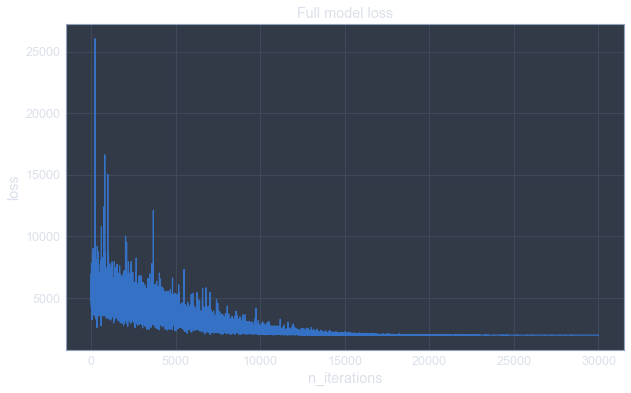

In [74]:
n_iterations = 30_000
n_samples = 5_000

# model
with pm.Model() as full_model:
    alpha = pm.Normal("alpha", mu=0, sigma=30)
    beta = pm.Normal("beta", mu=0, sigma=30, shape=X_train_subset.shape[1])
    # Prior over the variance of the noise
    sigma = pm.HalfCauchy("sigma", 5)

    # Linear regression model
    mu = alpha + pm.math.dot(beta, X_train_subset.T)

    likelihood = pm.Normal(
        "likelihood", mu=mu, sigma=sigma, observed=y_train_scaled[:, 0]
    )

    full_approx = pm.fit(n_iterations, method="advi")
    full_posterior = full_approx.sample(n_samples)
plt.figure(figsize=(10, 6))
plt.plot(full_approx.hist)
plt.title("Full model loss")
plt.xlabel("n_iterations")
plt.ylabel("loss")
plt.show()

In [75]:
def mean_absolute_error(y_true, y_pred):
    return np.mean(abs(y_true - y_pred))


def mape(y_true, y_pred):
    return np.mean(abs(y_true - y_pred) / y_true)


def predict(posterior, X, y_scaler):
    log_likelihood = np.mean(posterior["alpha"]) + np.dot(
        np.mean(posterior["beta"], axis=0), X.T
    )
    y_pred = np.power(10, y_scaler.inverse_transform(log_likelihood.reshape(-1, 1)))
    return y_pred


def evaluate(posterior, X, y, y_scaler):
    y_pred = predict(posterior, X, y_scaler)
    mae, mape_ = mean_absolute_error(y, y_pred), mape(y, y_pred)

    print("MAE = ", mae)
    print("MAPE = ", mape_)
    return y_pred

In [76]:
print("Full model results on the training set:")
y_pred_train = evaluate(full_posterior, X_train_subset, y_train_scaled, y_scaler)

Full model results on the training set:
MAE =  519211.25696440483
MAPE =  -829800.8593977917


In [77]:
print("Full model results on the test set:")
y_pred_val = evaluate(full_posterior, X_test_subset, y_test_scaled, y_scaler)

Full model results on the validation set:
MAE =  488357.032610717
MAPE =  -20627.492750177273


## Clustering

Let's try all possible combinations of feature clustering to try to identify the 'pieces' of the data.

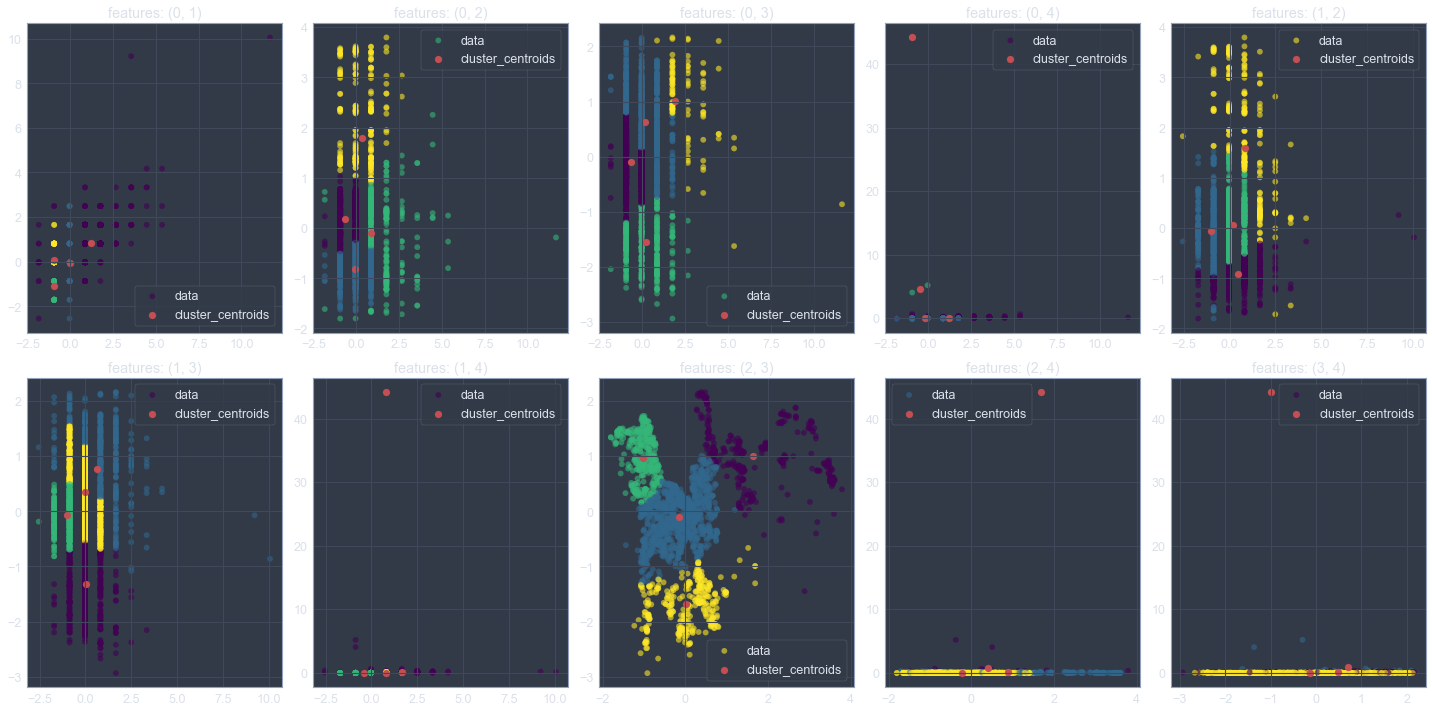

In [78]:
# training gaussian mixture model
from sklearn.mixture import GaussianMixture
from itertools import combinations

# Ideally, create a cluster for each feature
n_clusters = 4
gmm = GaussianMixture(n_components=n_clusters)

feature_combinations = combinations(features, 2)
fig, axes = plt.subplots(2, 5, figsize=(20, 10))

for ax, feat_idx in zip(axes.flatten(), feature_combinations):
    X_clustering = np.r_[X_train_subset[:, feat_idx]]
    X_cluster_labels = gmm.fit_predict(X_clustering)

    ax.scatter(
        X_clustering[:, 0],
        X_clustering[:, 1],
        alpha=0.6,
        label="data",
        c=X_cluster_labels,
    )
    ax.scatter(
        gmm.means_[:, 0],
        gmm.means_[:, 1],
        s=50,
        c="r",
        marker="o",
        label="cluster_centroids",
    )
    ax.set_title(f"features: {feat_idx}")
    ax.legend()
fig.tight_layout()
plt.show()

As suggested in the lecture, we'll use latitude and longitude (features 2, 3) to cluster the data points.

In [79]:
gmm = GaussianMixture(n_components=n_clusters)
feat_idx = [2, 3]

train_cluster_labels = gmm.fit_predict(X_train_subset[:, feat_idx])
test_cluster_labels = gmm.predict(X_test_subset[:, feat_idx])

### Clusters

In [80]:
# Training clusters
X_train_clusters = [
    X_train_subset[train_cluster_labels == idx] for idx in range(n_clusters)
]
y_train_clusters = [
    y_train_scaled[train_cluster_labels == idx].ravel() for idx in range(n_clusters)
]

print("Training cluster shapes:")
print(
    "\n".join(
        f"\tX_{idx}={X.shape}, y_{idx}={y.shape}"
        for idx, (X, y) in enumerate(zip(X_train_clusters, y_train_clusters))
    ),
)

Training cluster shapes:
	X_0=(316, 5), y_0=(316,)
	X_1=(1034, 5), y_1=(1034,)
	X_2=(300, 5), y_2=(300,)
	X_3=(352, 5), y_3=(352,)


In [82]:
# Test clusters
X_test_clusters = [
    X_test_subset[test_cluster_labels == idx] for idx in range(n_clusters)
]
y_valid_clusters = [
    y_test_scaled[test_cluster_labels == idx].ravel() for idx in range(n_clusters)
]

print("Test cluster shapes:")
print(
    "\n".join(
        f"\tX_{idx}={X.shape}, y_{idx}={y.shape}"
        for idx, (X, y) in enumerate(zip(X_test_clusters, y_valid_clusters))
    ),
)

Test cluster shapes:
	X_0=(63, 5), y_0=(63,)
	X_1=(268, 5), y_1=(268,)
	X_2=(86, 5), y_2=(86,)
	X_3=(83, 5), y_3=(83,)


## Piecewise Models

In [83]:
posteriors = []

for n in range(n_clusters):
    with pm.Model() as model:
        alpha = pm.Normal("alpha", mu=0, sigma=30)
        beta = pm.Normal("beta", mu=0, sigma=30, shape=X_train_clusters[n].shape[1])

        mu = alpha + pm.math.dot(beta, X_train_clusters[n].T)

        sigma = pm.HalfCauchy("sigma", 5)
        like = pm.Normal("like", mu=mu, sigma=sigma, observed=y_train_clusters[n])
        approximation = pm.fit(n_iterations, method="advi")
        posteriors.append(approximation.sample(n_samples))

Finished [100%]: Average Loss = 284.16


Finished [100%]: Average Loss = 931.88


Finished [100%]: Average Loss = 281.91


Finished [100%]: Average Loss = 318.38


## Simulations

First let's define some helper functions

In [84]:
# Posterior predictive checks (PPCs)
def ppc(alpha, beta, sigma, X, n_samples=500):
    # we select n_samples random samples from the posterior
    idx = np.random.randint(0, beta.shape[0], size=n_samples)
    alpha_idx = alpha[idx]
    beta_idx = beta[idx, :]
    sigma_idx = sigma[idx]

    y_pred = np.zeros((n_samples, X.shape[0]))
    for i in range(X.shape[0]):
        # we generate data from linear model
        y_pred = (
            alpha_idx
            + np.dot(beta_idx, X[i : i + 1, :].T).T
            + np.random.randn(len(sigma_idx)) * sigma_idx
        )
        # y_pred[:, i] = y_pred[0, :]
    return y_pred


def plot_ppc(
    y_true, y_pred, ax, remove_legend, n_samples=500, linewidth=0.2, alpha=0.3
):
    plot_kwargs = dict(linewidth=linewidth, alpha=alpha)

    # Plot the predictions
    # for row in range(len(y_pred)):
    az.plot_dist(y_pred, color="lightblue", ax=ax, plot_kwargs=plot_kwargs)
    az.plot_dist(
        y_pred, color="lightblue", ax=ax, label="predictions", plot_kwargs=plot_kwargs,
    )

    # Plot the true data
    plot_kwargs.update({"linewidth": 0.9, "alpha": 0.8})
    az.plot_dist(
        y_true,
        color="#ff491c",
        ax=ax,
        label="true observations",
        plot_kwargs=plot_kwargs,
    )

    if remove_legend:
        ax.get_legend().remove()

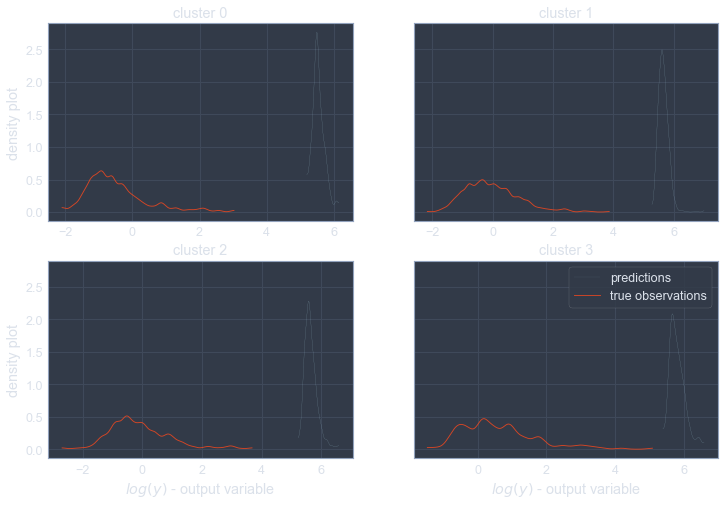

In [85]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=False, sharey=True)
piecewise_ppc = []
y_preds = []

for idx, ax in enumerate(axes.flatten()):
    y_pred = np.log10(
        predict(posteriors[idx], X_train_clusters[idx], y_scaler=y_scaler)
    )
    y_preds.append(y_pred)
    idx_ppc = ppc(
        posteriors[idx]["alpha"],
        posteriors[idx]["beta"],
        posteriors[idx]["sigma"],
        X_train_clusters[idx],
    )
    piecewise_ppc.append(idx_ppc)

    # Plotting
    remove_legend = True if idx != n_clusters - 1 else False
    plot_ppc(
        y_train_clusters[idx], y_pred, ax, remove_legend,
    )
    ax.set_title(f"cluster {idx}")
    if idx % 2 == 0:
        ax.set_ylabel("density plot")
    if idx > 1:
        ax.set_xlabel("$log({y})$ - output variable")
plt.show()

### Only Cluster 0

## Overall

## Test set performance

### PPC on the Test set



# SUMMARY